In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import relevant libraries
import os
import glob
import sys
sys.path.append('../../activedrops')

## Including ourselves
import numpy as np
import pivdrops
pivdrops.set_plotting_style()

In [5]:
def process_raw_plate_reader_data(file_path, sample_names, skiprows, nrows=None):
    """
    Process raw data from a plate reader.

    This function reads an Excel file, cleans up the data, and performs several transformations
    including numeric conversion, baseline subtraction, and time conversion.

    Parameters:
    - file_path (str): Path to the Excel file containing the raw data.
    - sample_names (list): List of sample names to be used in the data processing.
    - skiprows (int): Number of rows to skip at the beginning of the file.
    - nrows (int, optional): Number of rows to read from the file.

    Returns:
    - pd.DataFrame: Processed data with baseline subtraction and time conversion.
    """

    # Read Excel file with specified rows skipped and second row as header, and only a specified number of rows
    data = pd.read_excel(file_path, skiprows=skiprows, header=1, nrows=nrows)

    # Remove columns that are automatically named 'Unnamed' by pandas
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    # Drop irrelevant columns and remove any rows with NA values
    data = data.iloc[:,2:].dropna(axis=0)

    # Convert all data to numeric, coercing errors to NaN
    data = data.apply(pd.to_numeric, errors='coerce')

    # Subtract the last column values from each column for baseline correction
    last_column_values = data.iloc[:, -1]
    for col in data.columns:
        data[col] = data[col] - last_column_values

    # Reset index and create a time column (converting index to hours)
    data.reset_index(inplace=True)
    data['time (h)'] = data['index'] * 0.1666 # Assuming 10 minutes per index
    data.drop('index', axis=1, inplace=True)

    # Reorder columns to put 'time (h)' as the first column
    columns = ['time (h)'] + [col for col in data if col != 'time (h)']
    data = data[columns]

    # Additional baseline correction
    data_ = data.iloc[:,1:-1] - data.iloc[:,-1:].values
    data = pd.concat([data.iloc[:,:1], data_], axis=1)

    return data


def create_replacement_dict(array, names):
    """
    Create a dictionary for replacing elements in an array with corresponding names.

    Parameters:
    - array (list): A list of elements to be replaced.
    - names (list): A list of names for the replacement.

    Returns:
    - dict: A dictionary mapping elements from the array to names.

    Raises:
    - ValueError: If the number of unique elements in the array does not match the number of names.
    """

    # Extract unique first letters from the array elements
    unique_letters = sorted(set(item[0] for item in array))

    # Ensure that the number of unique letters matches the number of provided names
    if len(unique_letters) != len(names):
        raise ValueError("The number of names does not match the number of unique letters.")

    # Create and return the mapping dictionary
    return dict(zip(unique_letters, names))

def vals_to_nM(y):
    """
    Convert raw values to nanomolar (nM) units.

    Parameters:
    - y (float or pd.Series): The raw value or a pandas series of raw values.

    Returns:
    - float or pd.Series: The converted value(s) in nanomolar units.
    """
    return ((y + 2466.17) / 52763) * 1000

def plate_reader_to_df(file_path, sample_names, skiprows, nrows=None):
    """
    Convert plate reader data to a pandas DataFrame with processed values.

    This function processes raw data from a plate reader, replaces column names,
    converts values to nanomolar units, and calculates mean values for each sample type.

    Parameters:
    - file_path (str): Path to the Excel file containing the raw data.
    - sample_names (list): List of sample names for naming columns.
    - skiprows (int): Number of rows to skip at the beginning of the file.

    Returns:
    - pd.DataFrame: A DataFrame with processed and converted data.
    """

    # Process the raw data from the plate reader
    data = process_raw_plate_reader_data(file_path, sample_names, skiprows, nrows=nrows)

    # Extract the column names representing the plate wells
    plate_wells = data.columns[1:]

    # Create a dictionary to replace well identifiers with sample names
    replacement_dict = create_replacement_dict(plate_wells, sample_names)

    # Replace the well identifiers in column names with sample names
    counter_dict = {key: 0 for key in replacement_dict.keys()}
    new_columns = []
    for item in plate_wells:
        if item[0] in counter_dict:
            counter_dict[item[0]] += 1
            new_columns.append(f"{replacement_dict[item[0]]} {counter_dict[item[0]]}")

    data.columns = ['time (h)'] + new_columns

    # Convert values to nanomolar units
    for col in data.columns[1:]:
        data[col] = vals_to_nM(data[col])

    # Calculate and add mean columns for each sample type
    sample_columns = {sample: [col for col in data.columns if col.startswith(sample)] for sample in sample_names}
    for sample, columns in sample_columns.items():
        data[f"{sample} mean"] = data[columns].mean(axis=1)

    return data

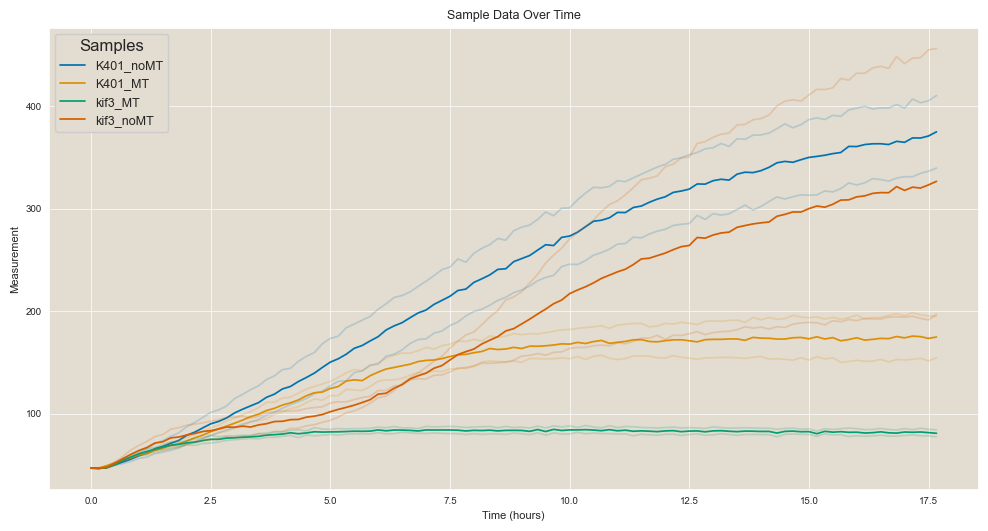

In [22]:
file_path = '../../data/plate_reader/093034-kva-Glu_g6p_pep_atp50_atp100_h2o-drops.xpt.xlsx'
sample_names = ['Glucose 15mM', 'G6P 15mM', 'PEP 15 mM', 'ATP 3.5mM', 'ATP 7mM', 'No nutrient']
skiprows = 49

file_path = '../../data/plate_reader/091723-kva-kif-MTvsNoMT.xpt.xlsx'
sample_names = ['K401_MT', 'K401_noMT', 'kif3_MT', 'kif3_noMT']
skiprows = 52

df = plate_reader_to_df(file_path, sample_names, skiprows, nrows=110)

def plot_sample_data(df):
    """
    Generates a plot from the DataFrame where each sample is represented with different shades
    of the same color for replicates and a solid line for the mean.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the processed data.
    """

    # Create a figure and axis for the plot
    plt.figure(figsize=(12, 6))
    
    # Extracting unique sample names from the DataFrame columns
    sample_names = set(col.rsplit(' ', 1)[0] for col in df.columns if 'mean' in col)

    # Assigning unique colors for each sample
    colors = sns.color_palette(n_colors=len(sample_names))

    # Plotting each sample's data
    for i, sample in enumerate(sample_names):
        sample_cols = [col for col in df.columns if col.startswith(sample) and 'mean' not in col]
        mean_col = f"{sample} mean"

        # Plot replicates with transparent versions of the color
        for col in sample_cols:
            plt.plot(df['time (h)'], df[col], color=np.append(colors[i], 0.2), label='_nolegend_')

        # Plot the mean with a solid color
        plt.plot(df['time (h)'], df[mean_col], color=colors[i], label=sample)

    # Adding title and labels
    plt.title("Sample Data Over Time")
    plt.xlabel("Time (hours)")
    plt.ylabel("Measurement")
    plt.legend(title="Samples")

    # Show the plot
    plt.show()

# To plot the data, call the function with your DataFrame
# plot_sample_data(your_dataframe)

# To plot the data, call the function with your DataFrame
plot_sample_data(df)


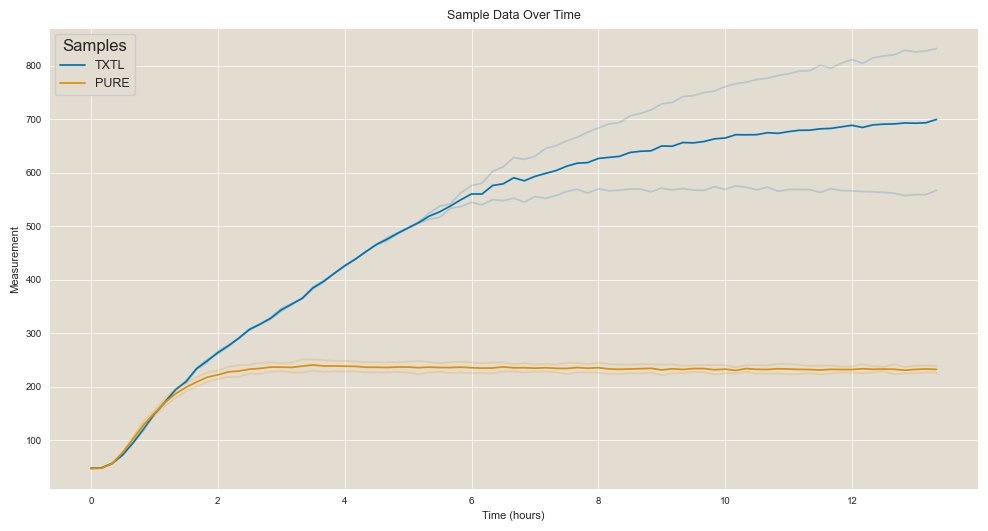

In [28]:

file_path = '../../data/plate_reader/082323-TXTL_PURE-2.xlsx'
sample_names = ['TXTL', 'PURE']
skiprows = 52

df = plate_reader_to_df(file_path, sample_names, skiprows, nrows=110)

def plot_sample_data(df):
    """
    Generates a plot from the DataFrame where each sample is represented with different shades
    of the same color for replicates and a solid line for the mean.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the processed data.
    """

    # Create a figure and axis for the plot
    plt.figure(figsize=(12, 6))
    
    # Extracting unique sample names from the DataFrame columns
    sample_names = set(col.rsplit(' ', 1)[0] for col in df.columns if 'mean' in col)

    # Assigning unique colors for each sample
    colors = sns.color_palette(n_colors=len(sample_names))

    # Plotting each sample's data
    for i, sample in enumerate(sample_names):
        sample_cols = [col for col in df.columns if col.startswith(sample) and 'mean' not in col]
        mean_col = f"{sample} mean"

        # Plot replicates with transparent versions of the color
        for col in sample_cols:
            plt.plot(df['time (h)'], df[col], color=np.append(colors[i], 0.2), label='_nolegend_')

        # Plot the mean with a solid color
        plt.plot(df['time (h)'], df[mean_col], color=colors[i], label=sample)

    # Adding title and labels
    plt.title("Sample Data Over Time")
    plt.xlabel("Time (hours)")
    plt.ylabel("Measurement")
    plt.legend(title="Samples")

    # Show the plot
    plt.show()


# To plot the data, call the function with your DataFrame
plot_sample_data(df)

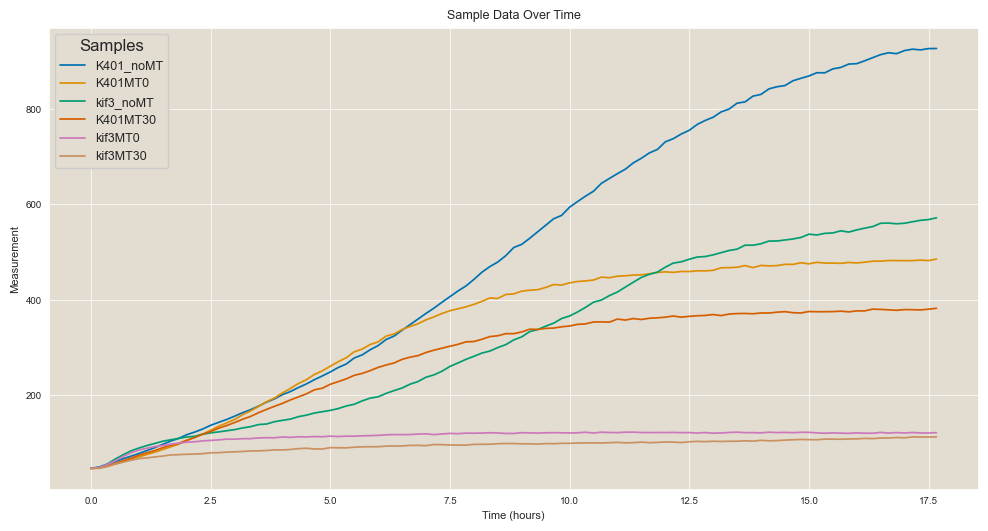

In [34]:

file_path = '../../data/plate_reader/091723-kva_kiva-noMT_MT30_MT0-3rxeach.xpt.xlsx'
sample_names = ['K401_noMT', 'K401MT30', 'K401MT0', 'kif3_noMT', 'kif3MT30', 'kif3MT0']
skiprows = 49

df = plate_reader_to_df(file_path, sample_names, skiprows, nrows=110)

def plot_sample_data(df):
    """
    Generates a plot from the DataFrame where each sample is represented with different shades
    of the same color for replicates and a solid line for the mean.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the processed data.
    """

    # Create a figure and axis for the plot
    plt.figure(figsize=(12, 6))
    
    # Extracting unique sample names from the DataFrame columns
    sample_names = set(col.rsplit(' ', 1)[0] for col in df.columns if 'mean' in col)

    # Assigning unique colors for each sample
    colors = sns.color_palette(n_colors=len(sample_names))

    # Plotting each sample's data
    for i, sample in enumerate(sample_names):
        sample_cols = [col for col in df.columns if col.startswith(sample) and 'mean' not in col]
        mean_col = f"{sample} mean"

        # # Plot replicates with transparent versions of the color
        # for col in sample_cols:
        #     plt.plot(df['time (h)'], df[col], color=np.append(colors[i], 0.2), label='_nolegend_')

        # Plot the mean with a solid color
        plt.plot(df['time (h)'], df[mean_col], color=colors[i], label=sample)

    # Adding title and labels
    plt.title("Sample Data Over Time")
    plt.xlabel("Time (hours)")
    plt.ylabel("Measurement")
    plt.legend(title="Samples")

    # Show the plot
    plt.show()


# To plot the data, call the function with your DataFrame
plot_sample_data(df)